In [24]:
import os
import pandas as pd
import random
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from typing import Dict, TypedDict

# Load environment variables
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [25]:
%pwd

'd:\\Rahul-Github\\Daily-Task\\Agentic-AI\\practice'

In [26]:
# Load datasets
inventory = pd.read_csv("./data/inventory_latest.csv")
customers = pd.read_csv("./data/customers_latest.csv")

In [27]:
inventory.head()

,item_id,category,stock,weight,price
0,item_1,electronics,177,8.19,272.96
1,item_2,books,22,8.67,135.61
2,item_3,home,189,9.02,285.38
3,item_4,books,139,3.05,346.13
4,item_5,sports,85,2.19,491.50


In [28]:
customers.head()

,customer_id,name,location
0,customer_1,Customer_1,local
1,customer_2,Customer_2,local
2,customer_3,Customer_3,local
3,customer_4,Customer_4,domestic
4,customer_5,Customer_5,domestic


In [29]:
class State(TypedDict):
    query: str
    category: str
    next_node: str
    item_id: str
    order_status: str
    cost: str
    payment_status: str
    location: str
    quantity: int

In [30]:
# Initialize LLM and bind tools
llm = ChatGroq(model="qwen-2.5-32b", temperature=0)

In [31]:
@tool
def cancel_order(query: str) -> dict:
    """Simulate order cancelling"""
    order_id = llm.with_structured_output(method='json_mode').invoke(f'Extract order_id from the following text in json format: {query}')['order_id']
    #amount = query.get("amount")

    if not order_id:
        return {"error": "Missing 'order_id'."}

    return {"order_status": "Order stands cancelled"}

In [32]:
tools_2 = [cancel_order]
llm_with_tools_2 = llm.bind_tools(tools_2)
tool_node_2 = ToolNode(tools_2)

In [41]:
def call_model_2(state: MessagesState):
    """Use the LLM to decide the next step."""
    messages = state["messages"]
    response = llm_with_tools_2.invoke(str(messages))
    return {"messages": [response]}


def call_tools_2(state: MessagesState) -> Literal["tools_2", END]:
    """Route workflow based on tool calls."""
    messages = state["messages"]
    last_message = messages[-1]

    if last_message.tool_calls:
        return "tools_2"
    return END


In [34]:
def categorize_query(state: MessagesState) -> MessagesState:
    """Categorize user query into PlaceOrder or CancelOrder"""
    prompt = ChatPromptTemplate.from_template(
        "Categorize user query into PlaceOrder or CancelOrder"
        "Respond with either 'PlaceOrder', 'CancelOrder' Query: {state}"
    )

    chain = prompt | ChatGroq(temperature=0)
    category = chain.invoke({"state": state}).content
    
    return {"query":state,"category": category}

In [35]:
def check_inventory(state: MessagesState) -> MessagesState:
    """Check if the requested item is in stock."""

    item_id = llm.with_structured_output(method='json_mode').invoke(f'Extract item_id from the following text in json format: {state}')['item_id']
    quantity = llm.with_structured_output(method='json_mode').invoke(f'Extract quantity from the following text in json format: {state}')['quantity']

    if not item_id or not quantity:
        return {"error": "Missing 'item_id' or 'quantity'."}

    if inventory.get(item_id, {}).get("stock", 0) >= quantity:
        print("IN STOCK")
        return {"status": "In Stock"}
    return {"query":state,"order_status": "Out of Stock"}

In [36]:
def compute_shipping(state: MessagesState) -> MessagesState:
    """Calculate shipping costs."""
    item_id = llm.with_structured_output(method='json_mode').invoke(f'Extract item_id from the following text in json format: {state}')['item_id']
    quantity = llm.with_structured_output(method='json_mode').invoke(f'Extract quantity from the following text in json format: {state}')['quantity']
    customer_id = llm.with_structured_output(method='json_mode').invoke(f'Extract customer_id from the following text in json format: {state}')['customer_id']
    location = customers[customer_id]['location']


    if not item_id or not quantity or not location:
        return {"error": "Missing 'item_id', 'quantity', or 'location'."}

    weight_per_item = inventory[item_id]["weight"]
    total_weight = weight_per_item * quantity
    rates = {"local": 5, "domestic": 10, "international": 20}
    cost = total_weight * rates.get(location, 10)
    print(cost,location)

    return {"query":state,"cost": f"${cost:.2f}"}

In [37]:
def process_payment(state: State) -> State:
    """Simulate payment processing."""
    cost = llm.with_structured_output(method='json_mode').invoke(f'Extract cost from the following text in json format: {state}')

    if not cost:
        return {"error": "Missing 'amount'."}
    print(f"PAYMENT PROCESSED: {cost} and order successfully placed!")
    payment_outcome = random.choice(["Success", "Failed"])
    return {"payment_status": payment_outcome}

In [38]:
def route_query_1(state: State) -> str:
    """Route the query based on its category."""
    print(state)
    if state["category"] == "PlaceOrder":
        return "PlaceOrder"
    elif state["category"] == "CancelOrder":
        return "CancelOrder"

In [42]:
# Create the workflow
workflow = StateGraph(MessagesState)

#Add nodes
workflow.add_node("RouteQuery", categorize_query)
workflow.add_node("CheckInventory", check_inventory)
workflow.add_node("ComputeShipping", compute_shipping)
workflow.add_node("ProcessPayment", process_payment)

workflow.add_conditional_edges(
    "RouteQuery",
    route_query_1,
    {
        "PlaceOrder": "CheckInventory",
        "CancelOrder": "CancelOrder"
    }
)
workflow.add_node("CancelOrder", call_model_2)
workflow.add_node("tools_2", tool_node_2)


# Define edges

workflow.add_edge(START, "RouteQuery")
workflow.add_edge("CheckInventory", "ComputeShipping")
workflow.add_edge("ComputeShipping", "ProcessPayment")
workflow.add_conditional_edges("CancelOrder", call_tools_2)
workflow.add_edge("tools_2", "CancelOrder")
workflow.add_edge("ProcessPayment", END)

app=workflow.compile()

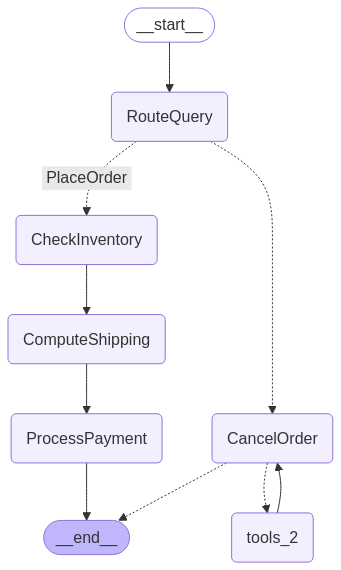

In [43]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage

messages=app.invoke({"messages":HumanMessage(content="I wish to cancel order_id 223")})
for m in messages['messages']:
    m.pretty_print()

{'query': {'messages': [HumanMessage(content='I wish to cancel order_id 223', additional_kwargs={}, response_metadata={}, id='1ff390dd-66f7-47cf-91ae-d469e3c73648')]}, 'category': 'CancelOrder', 'messages': [HumanMessage(content='I wish to cancel order_id 223', additional_kwargs={}, response_metadata={}, id='1ff390dd-66f7-47cf-91ae-d469e3c73648')]}
================================ Human Message =================================

I wish to cancel order_id 223
================================== Ai Message ==================================
Tool Calls:
  cancel_order (call_sjv3)
 Call ID: call_sjv3
  Args:
    query: order_id 223
================================= Tool Message =================================
Name: cancel_order

{"order_status": "Order stands cancelled"}
================================== Ai Message ==================================

The order with ID 223 has been successfully cancelled.
